In [334]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, rosen
from pandas import DataFrame
import random
import time

plt.rcParams["figure.figsize"] = (20, 10)

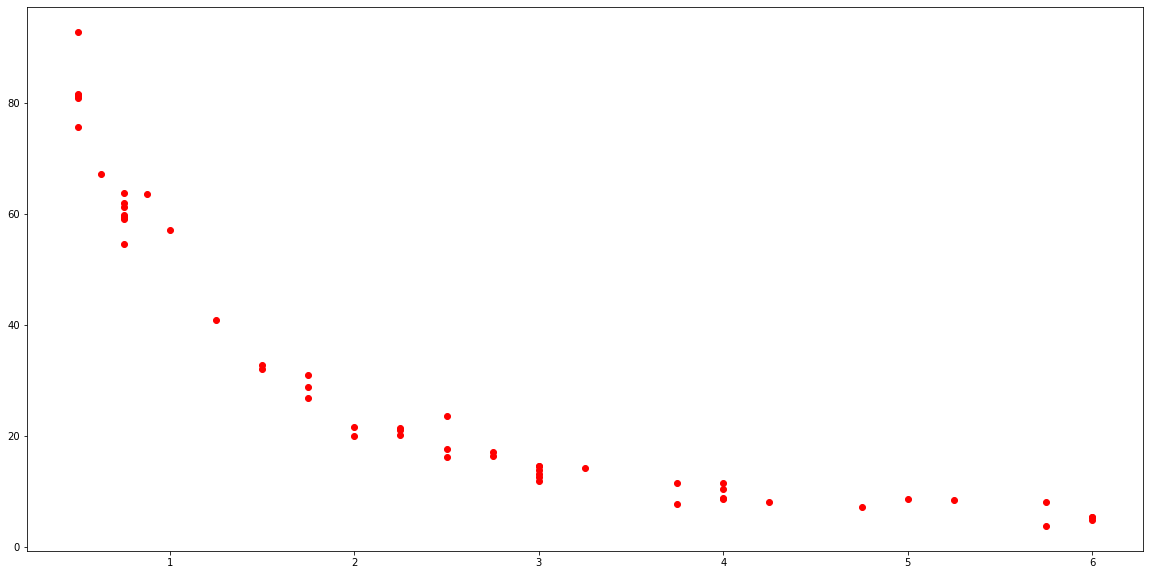

In [335]:
data = pd.read_csv("Chwirut2.csv")
x_data = data['x']
y_data = data['y']
plt.plot(x_data, y_data, 'ro')

Model: $y = \frac{exp(-b_1*x)}{b_2+b_3*x}  +  e$
exp_beta_1 = 1.6657666537E-01
exp_beta_2 = 5.1653291286E-03
exp_beta_3 = 1.2150007096E-02

In [336]:
def func(x, b1, b2, b3):
    y = np.e ** (-b1 * x) / (b2 + b3 * x)
    return y

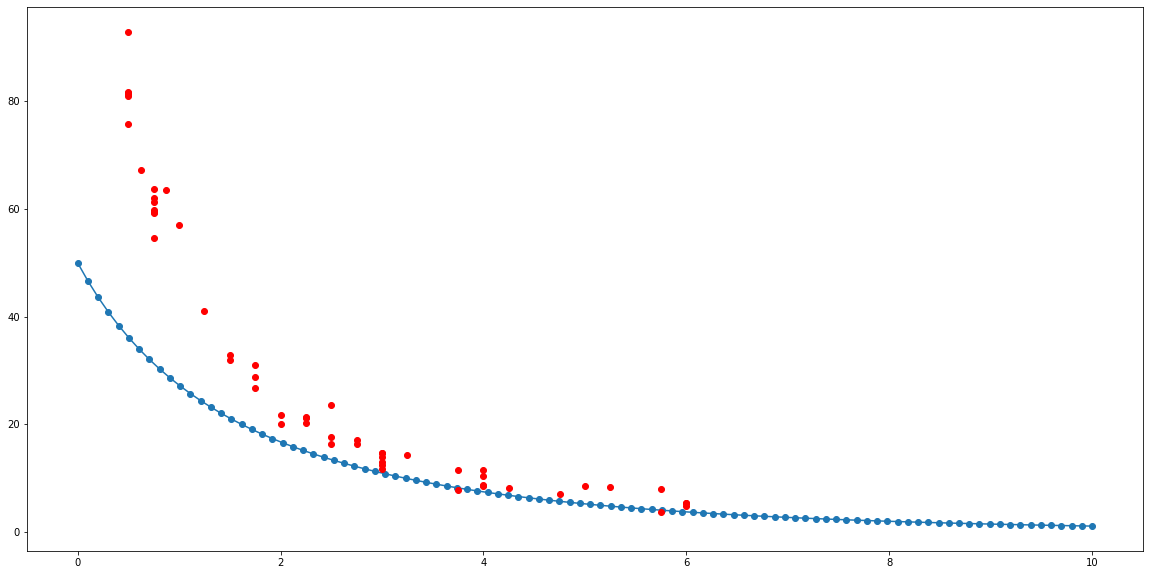

In [337]:
x = np.linspace(0, 10, 100)
plt.plot(x, func(x, 0.2, 0.02, 0.01), '-o')

plt.plot(x_data, y_data, 'ro')

In [338]:
def minimizing_func(b, idxs):
    res = 0
    for i in idxs:
        res += (func(x_data[i], b[0], b[1], b[2]) - y_data[i]) ** 2
    return res

def partial(f, i, x, idxs):
    h = 1e-3
    x[i] = x[i] + h
    right = f(x, idxs)
    x[i] = x[i] - 2 * h
    left = f(x, idxs)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad(f, x, idx_of_term, idx_of_var):
    return partial(f, idx_of_var, x, idx_of_term)

def const_lr(n, start):
    return start


def exp_lr(n, start):
    k = 0.01
    return start * np.exp(-k * n)


In [339]:
# p = -(J^T * J)^(-1) J * r

def calcP(x):
    res = list()
    for i in range(3):
        row = list()
        for j in range(54):
            row.append(grad(minimizing_func, x, [j], i))
        res.append(row)
    J = np.array(res)
    J = J.transpose()
    JT = J.transpose()
    Mul = np.matmul(JT, J)
    rev = np.linalg.inv(Mul)
    anti = -rev
    hh = np.matmul(anti, JT)
    rs = list()
    for i in range(54):
        rs.append(minimizing_func(x, [i]))
    rsnp = np.array(rs)
    rstr = rsnp.transpose()
    res = np.matmul(hh, rstr)
    return res

def newton(f, lr, start, lr_strategy=const_lr, epoch=20):
    x = start
    points = np.zeros((epoch, 3))
    points[0] = x
    for i in range(1, epoch):
        p = calcP(x)
        x = x + lr_strategy(i, lr) * np.array(p)
        points[i] = x

    return points

In [340]:
points = newton(minimizing_func, 0.9, [0.2, 0.02, 0.01], lr_strategy=exp_lr, epoch=10)

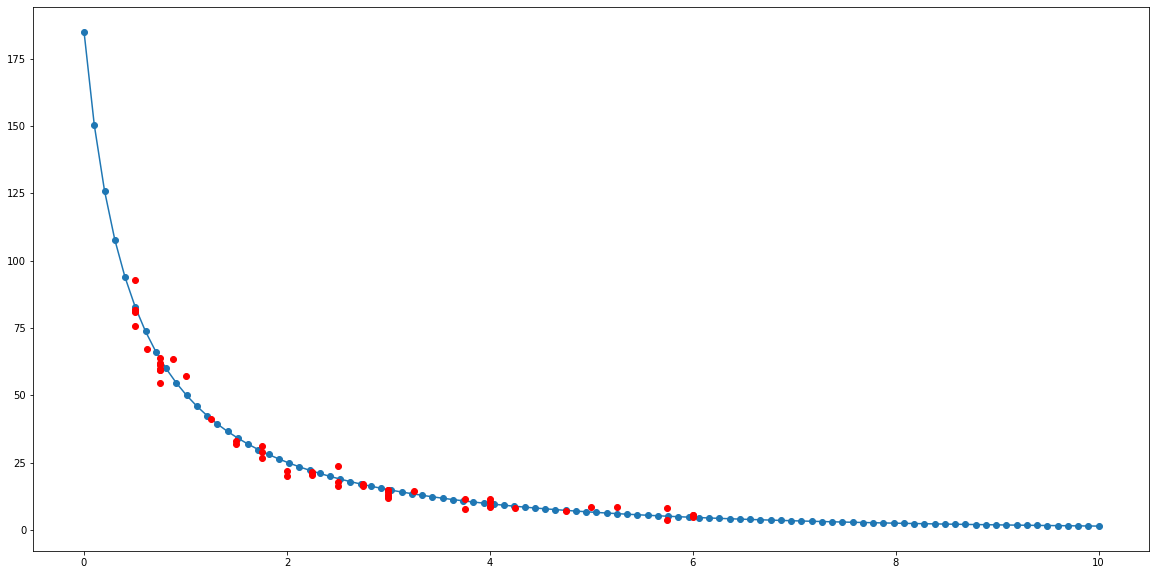

In [341]:
ans = points[-1]
x = np.linspace(0, 10, 100)
plt.plot(x, func(x, ans[0], ans[1], ans[2]), '-o')

plt.plot(x_data, y_data, 'ro')

In [342]:
ans

array([0.18214389, 0.0054068 , 0.01113037])